# Module 2: An unsupervised learning excersize in comparing XRF and MS data
## Data: IODP382-u1537A
Joseph Ruggiero


In [1]:
#tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial import cKDTree
from sklearn.mixture import GaussianMixture

import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
ms_file = pd.read_csv('https://raw.githubusercontent.com/JoeRuggieroStudent/ML_Projects/refs/heads/main/382_1537_MS.csv')
xrf_file = pd.read_csv('https://raw.githubusercontent.com/JoeRuggieroStudent/ML_Projects/main/382_U1537A_XRF.csv')


In [3]:
xrf_file.head()

,Expedition,Site,Hole,Core,Type,Section,A/W,Offset (mm),Depth,CSF-B (m),...,Mo,Ag,Ba,Instrument,Scan Number,Date of Measure,Time of Measure,Uploaded By,Date Uploaded,Comment
0,382,U1537,A,2,H,2,A,20,4.02,3.986,...,5,289414,5055,XRF1,1,10/2/2019,13:21:14,LEVAY_B,11/1/2019 21:34,~1mm accessory; with film; XRF 1
1,382,U1537,A,2,H,2,A,40,4.04,4.006,...,24,279078,6079,XRF1,1,10/2/2019,13:21:37,LEVAY_B,11/1/2019 21:34,~1mm accessory; with film; XRF 1
2,382,U1537,A,2,H,2,A,60,4.06,4.026,...,71,277475,5624,XRF1,1,10/2/2019,13:22:01,LEVAY_B,11/1/2019 21:34,~1mm accessory; with film; XRF 1
3,382,U1537,A,2,H,2,A,80,4.08,4.046,...,75,279872,6143,XRF1,1,10/2/2019,13:22:25,LEVAY_B,11/1/2019 21:34,~1mm accessory; with film; XRF 1
4,382,U1537,A,2,H,2,A,100,4.10,4.066,...,51,279679,6046,XRF1,1,10/2/2019,13:22:48,LEVAY_B,11/1/2019 21:34,~1mm accessory; with film; XRF 1


Because the these two datasets are not measured at exactly the same depth, below I performed a nearest neighbor join of the two datasets along the depth column.  Its not perfect, but my hope is that overall is merges the two datasets well enough to work together and be comparable

In [4]:
# Convert depths to NumPy arrays
xrf_depths = xrf_file['Depth'].values
ms_depths = ms_file['Depth'].values

# Use cKDTree for nearest neighbor search
tree = cKDTree(ms_depths.reshape(-1, 1))
distances, indices = tree.query(xrf_depths.reshape(-1, 1))

# Set a tolerance for matching (e.g., 0.1 meters)
tolerance = 0.1
xrf_file['Magnetic Susceptibility'] = np.where(
    distances <= tolerance,
    ms_file['MS'].values[indices],
    np.nan  # Use NaN if no close match is found
)

xrf_file.head()


,Expedition,Site,Hole,Core,Type,Section,A/W,Offset (mm),Depth,CSF-B (m),...,Ag,Ba,Instrument,Scan Number,Date of Measure,Time of Measure,Uploaded By,Date Uploaded,Comment,Magnetic Susceptibility
0,382,U1537,A,2,H,2,A,20,4.02,3.986,...,289414,5055,XRF1,1,10/2/2019,13:21:14,LEVAY_B,11/1/2019 21:34,~1mm accessory; with film; XRF 1,6.67
1,382,U1537,A,2,H,2,A,40,4.04,4.006,...,279078,6079,XRF1,1,10/2/2019,13:21:37,LEVAY_B,11/1/2019 21:34,~1mm accessory; with film; XRF 1,5.67
2,382,U1537,A,2,H,2,A,60,4.06,4.026,...,277475,5624,XRF1,1,10/2/2019,13:22:01,LEVAY_B,11/1/2019 21:34,~1mm accessory; with film; XRF 1,5.33
3,382,U1537,A,2,H,2,A,80,4.08,4.046,...,279872,6143,XRF1,1,10/2/2019,13:22:25,LEVAY_B,11/1/2019 21:34,~1mm accessory; with film; XRF 1,5.33
4,382,U1537,A,2,H,2,A,100,4.10,4.066,...,279679,6046,XRF1,1,10/2/2019,13:22:48,LEVAY_B,11/1/2019 21:34,~1mm accessory; with film; XRF 1,6.33


In order to use the elemental data, we need to normalize it because each sample isn't taken at the same resolution

In [5]:
# Define the columns to normalize (elements)
elements = ['Ca', 'Fe', 'Ni', 'As', 'Br', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Ag', 'Ba']

# Normalize each element by the row-wise sum of all elements
xrf_file[elements] = xrf_file[elements].div(xrf_file[elements].sum(axis=1), axis=0)

# Check the first few rows of the normalized data
print(xrf_file.head())


   Expedition   Site Hole  Core Type  Section A/W  Offset (mm)  Depth  \
0         382  U1537    A     2    H        2   A           20   4.02   
1         382  U1537    A     2    H        2   A           40   4.04   
2         382  U1537    A     2    H        2   A           60   4.06   
3         382  U1537    A     2    H        2   A           80   4.08   
4         382  U1537    A     2    H        2   A          100   4.10   

   CSF-B (m)  ...        Ag        Ba  Instrument  Scan Number  \
0      3.986  ...  0.926205  0.016177        XRF1            1   
1      4.006  ...  0.914635  0.019923        XRF1            1   
2      4.026  ...  0.917009  0.018586        XRF1            1   
3      4.046  ...  0.914587  0.020075        XRF1            1   
4      4.066  ...  0.917191  0.019828        XRF1            1   

   Date of Measure  Time of Measure  Uploaded By    Date Uploaded  \
0        10/2/2019         13:21:14      LEVAY_B  11/1/2019 21:34   
1        10/2/2019        

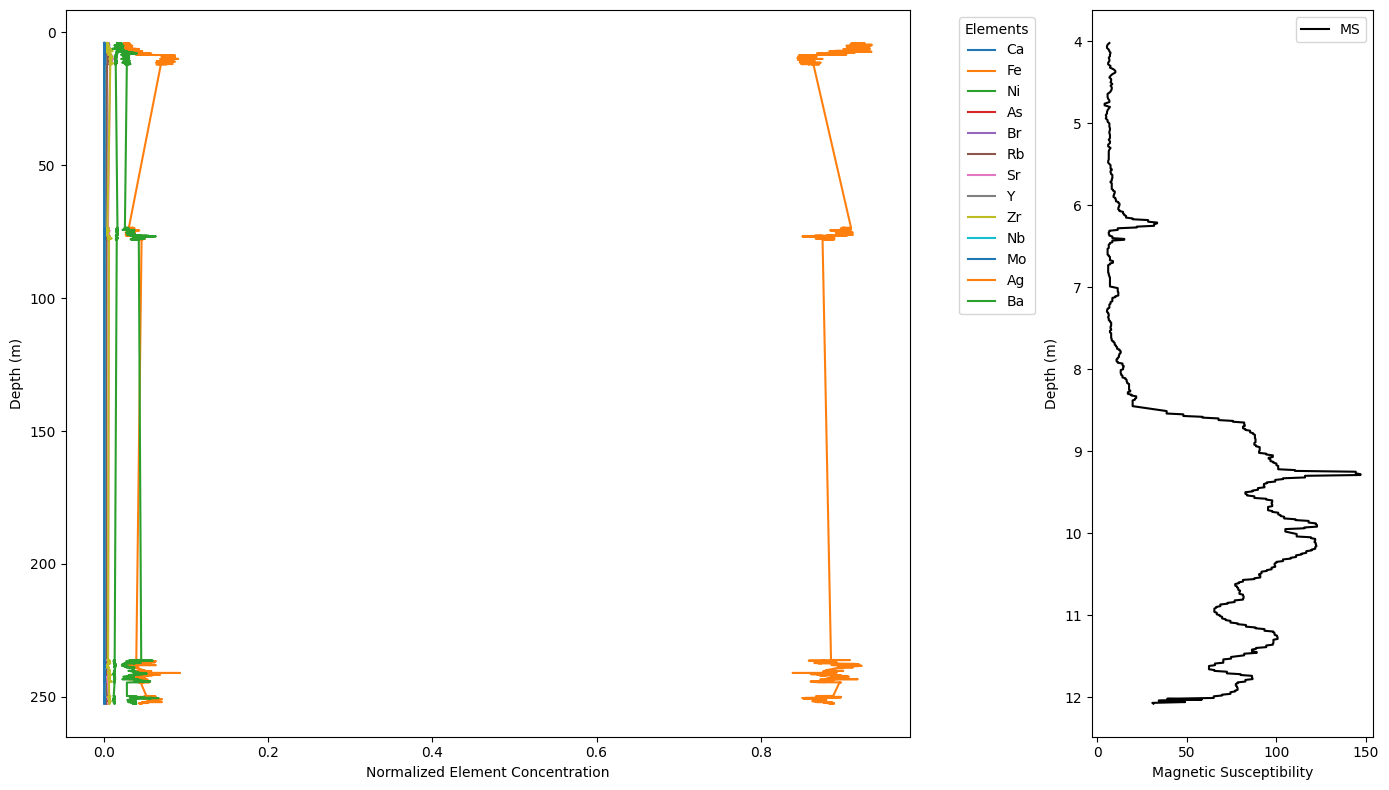

In [6]:
import matplotlib.pyplot as plt

# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8), gridspec_kw={'width_ratios': [3, 1]})
element_ax = axes[0]
ms_ax = axes[1]

# Plot normalized elements against depth in the left subplot
for element in elements:
    element_ax.plot(xrf_file[element], xrf_file['Depth'], label=element)

# Set labels and invert the y-axis for depth
element_ax.set_xlabel('Normalized Element Concentration')
element_ax.set_ylabel('Depth (m)')
element_ax.invert_yaxis()  # Depth increases downwards
element_ax.legend(title='Elements', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot MS data against depth in the right subplot
ms_ax.plot(xrf_file['Magnetic Susceptibility'], xrf_file['Depth'], color='black', label='MS')

# Set labels and invert the y-axis for depth
ms_ax.set_xlabel('Magnetic Susceptibility')
ms_ax.set_ylabel('Depth (m)')
ms_ax.invert_yaxis()  # Depth increases downwards
ms_ax.legend(loc='upper right')

# Adjust layout for clarity
plt.tight_layout()
plt.show()


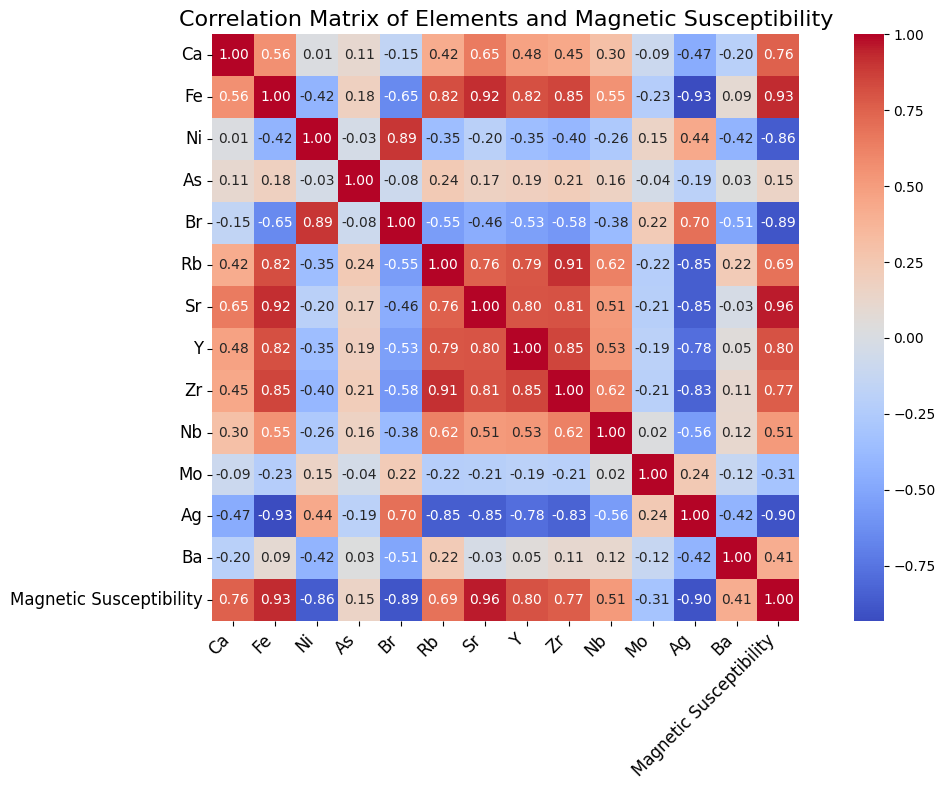

In [7]:
# Assuming 'xrf_file' is your DataFrame containing the data

# Define the columns of interest
columns_of_interest = ['Ca', 'Fe', 'Ni', 'As', 'Br', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Ag', 'Ba', 'Magnetic Susceptibility']

# Calculate the correlation matrix
correlation_matrix = xrf_file[columns_of_interest].corr(method='pearson')

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)

# Add labels and title
plt.title("Correlation Matrix of Elements and Magnetic Susceptibility", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


From this Pearson Correlation.  We see that MS has a strong positive relationship with Ca, Fe, Sr, and Y.  Fe makes sense because MS records the amount of magnetic material in a sample, which includes iron.

# Principal Components Analysis

Below you will see my attempts at PCA to compare elemental abundances and MS.  My above pearson correlation matrix suggests that a relationship exists, but below you will see that I unfortunately failed to quantify it with PCA.

In [8]:
# Assuming 'xrf_file' is your DataFrame and you want to include both elements and MS in the analysis
features = ['Ca', 'Fe', 'Ni', 'As', 'Br', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Ag', 'Ba', 'Magnetic Susceptibility']

# Extract the features for PCA
x = xrf_file[features].values


In [9]:
# Check for NaN values in the dataset
print(xrf_file[features].isna().sum())


Ca                           0
Fe                           0
Ni                           0
As                           0
Br                           0
Rb                           0
Sr                           0
Y                            0
Zr                           0
Nb                           0
Mo                           0
Ag                           0
Ba                           0
Magnetic Susceptibility    964
dtype: int64


In [10]:
# Replace NaN values with the column mean
xrf_file_filled = xrf_file[features].fillna(xrf_file[features].mean())

# Now perform PCA on the filled dataset
x = xrf_file_filled.values

# Perform PCA (No Standardization)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])


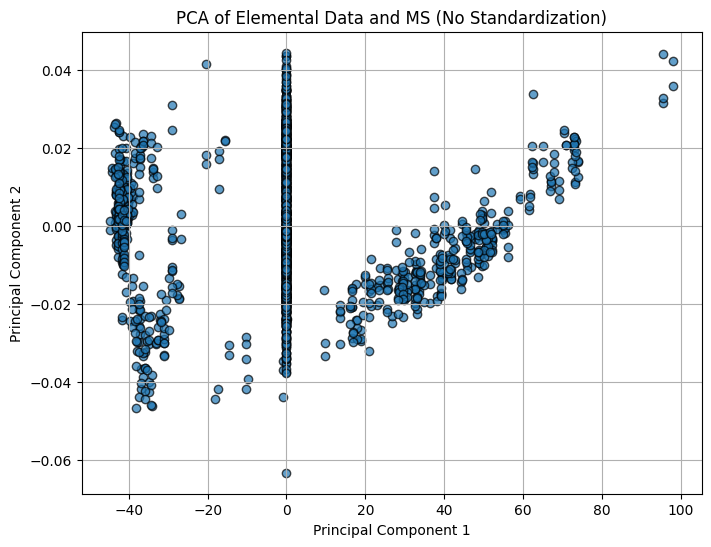

Explained Variance Ratio: [9.99999476e-01 3.97092310e-07]


In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7, edgecolor='k')
plt.title('PCA of Elemental Data and MS (No Standardization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

# Explained variance
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)


Above we see a PCA of the elemental variables and Magnetic susceptibility.  Because MS values are so much higher than the elemental values, the PCA looks crazy.  Instead of handling that, lets just perform a PCA and the elemental data for now.

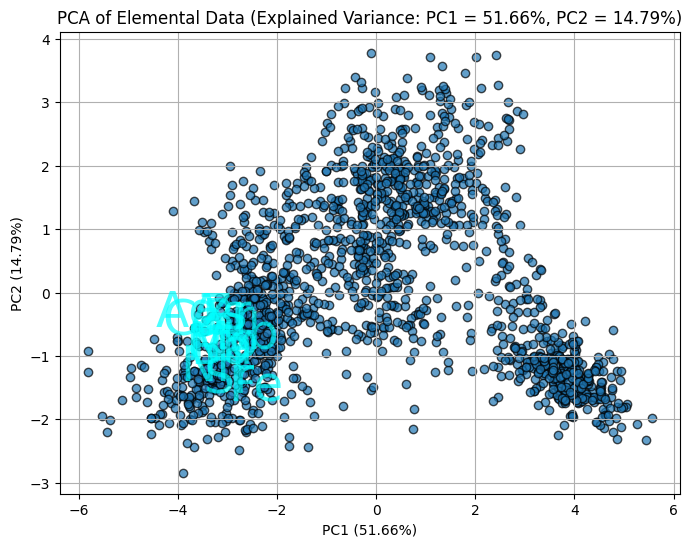

In [17]:
# Assuming 'xrf_file' contains your elemental data, and 'elemental_features' is a list of your element columns
elemental_features = ['Ca', 'Fe', 'Ni', 'As', 'Br', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Ag', 'Ba']

# Extract the relevant columns for PCA
x = xrf_file[elemental_features].values

# Standardizing the data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Perform PCA
pca = PCA(n_components=2)  # We want the first two components (PC1, PC2)
pca_components = pca.fit_transform(x_scaled)

# Extract the explained variance ratio (for the axes labels)
explained_variance = pca.explained_variance_ratio_

# Create a DataFrame to store the PCA components
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])

# Plot the PCA results
plt.figure(figsize=(8, 6))

# Scatter plot for PCA points (each element as a point in the PCA space)
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7, edgecolor='k')

# Label each point with its corresponding element
for i, feature in enumerate(elemental_features):
    plt.text(pca_df['PC1'][i] + 0.05, pca_df['PC2'][i] + 0.05, feature, fontsize=35, alpha=0.7, ha='left', va='bottom', color='cyan')

# Title with explained variance for each component
plt.title(f'PCA of Elemental Data (Explained Variance: PC1 = {explained_variance[0]*100:.2f}%, PC2 = {explained_variance[1]*100:.2f}%)')

# Labels for axes
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)')

# Add a grid
plt.grid(True)

# Show the plot
plt.show()


So visually, it does look like there are some trends within this data, but its really hard to tell as all of the elemental labels are clustered at the bottom left.  I think that this is because there are too many elements that are weighting the data, so next, I am going to try to run a PCA on just a few: Ca, Fe, and MS

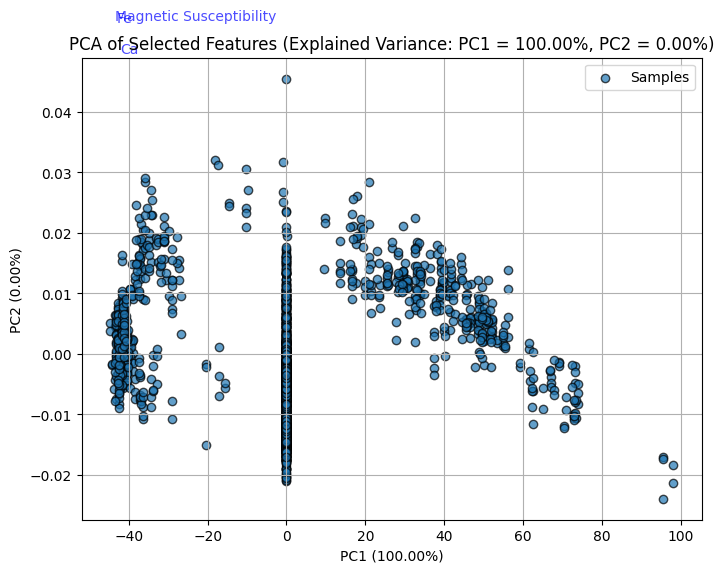

In [18]:
# Define the features to include in PCA
selected_features = ['Ca', 'Fe', 'Magnetic Susceptibility']  # Replace with your actual column names

# Extract the relevant columns for PCA
x_selected = xrf_file[selected_features]

# Handle missing values (e.g., impute mean values)
x_selected = x_selected.fillna(x_selected.mean())

# Perform PCA
pca = PCA(n_components=2)  # First two principal components
pca_components = pca.fit_transform(x_selected)

# Extract explained variance ratio for labeling
explained_variance = pca.explained_variance_ratio_

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])

# Plot the PCA results
plt.figure(figsize=(8, 6))

# Scatter plot for PCA points
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7, edgecolor='k', label='Samples')

# Add text labels for features (optional, adjust if needed)
for i, feature in enumerate(selected_features):
    plt.text(pca_df['PC1'][i] + 0.05, pca_df['PC2'][i] + 0.05, feature,
             fontsize=10, alpha=0.7, ha='left', va='bottom', color='blue')

# Title with explained variance for each component
plt.title(f'PCA of Selected Features (Explained Variance: PC1 = {explained_variance[0]*100:.2f}%, PC2 = {explained_variance[1]*100:.2f}%)')

# Labels for axes
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)')

# Add a grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


In [19]:
# Loadings (how much each feature contributes to each principal component)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=selected_features)

# Inspect contributions
print(loadings)


                              PC1       PC2
Ca                       0.000008  0.010940
Fe                       0.000523  0.999940
Magnetic Susceptibility  1.000000 -0.000523


Okay interesting.  I am not entirely sure why the labels are way up on the left, but PC1 value of 100 suggests that 100% of the variability in the dataset is explained by a dominant trend between Ca, Fe, and MS, which makes sense because MS is going to directly respond to iron concentration in a sample.  However, it also might suggest that one variable has a much stronger contribution to this dataset.  Because this data was not standardized, it is probable that MS is having this higher contribution.  Below, I calculated how much each feature contributed to each principal component and for PC1 MS is 1.00, suggesting that it is biasing the PCA in a not very meaningful way.  To keep exploring with PCA before I move on to a different method, lets see if we can determine the relationships between some other elements, and also calculate Ca/Fe and Ti/Al ratios.  

The point of this project is to use unsupervised learning to establish relationships between elemental compositions in sediment samples.

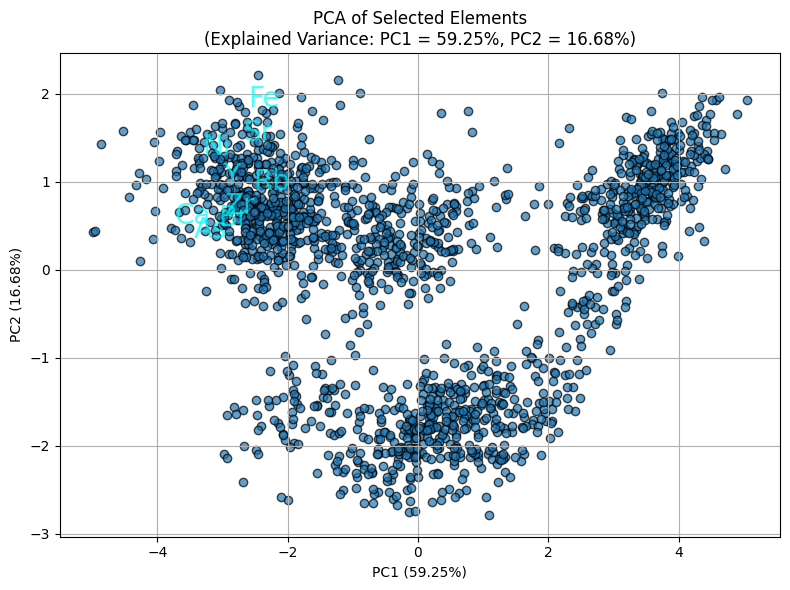

In [20]:
# Specify the elements to include in PCA
elemental_features = ['Ca', 'Fe', 'Ni', 'As', 'Br', 'Rb', 'Sr', 'Y', 'Zr']

# Extract the relevant columns for PCA
x = xrf_file[elemental_features].dropna()  # Drop rows with NaN values

# Standardize the data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Perform PCA
pca = PCA(n_components=2)  # Calculate the first two principal components
pca_components = pca.fit_transform(x_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Create a DataFrame for PCA components
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])

# Plot the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7, edgecolor='k')

# Add element labels for visualization
for i, feature in enumerate(elemental_features):
    plt.text(pca_df['PC1'][i] + 0.05, pca_df['PC2'][i] + 0.05, feature, fontsize=20, alpha=0.7, color='cyan')

# Add plot title and axis labels with explained variance
plt.title(f'PCA of Selected Elements\n(Explained Variance: PC1 = {explained_variance[0]*100:.2f}%, PC2 = {explained_variance[1]*100:.2f}%)')
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


Here I think we have the same issue as when we tried to examine MS.  One element (Ag) has a much higher abundance in each sample, as can be seen in the graph above where I plotted normalized abundances of each.  To see if we can get anything meaningful, below I removed Ag to test if that ellucidates any relationships between the other elements in a meaningful way.

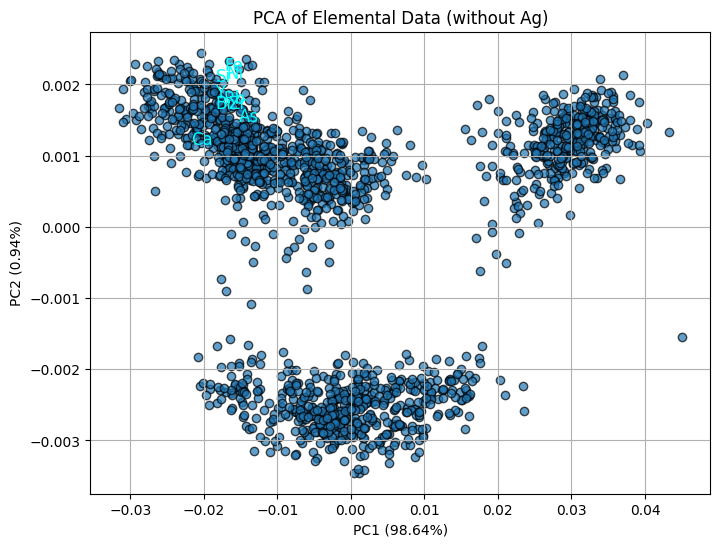

In [21]:
# Update the list of elements by removing 'Ag' (silver)
elemental_features = ['Ca', 'Fe', 'Ni', 'As', 'Br', 'Rb', 'Sr', 'Y', 'Zr']  # Removed 'Ag'

# Extract the relevant columns for PCA
x = xrf_file[elemental_features].values

# Perform PCA without Ag
pca = PCA(n_components=2)  # We want the first two components (PC1, PC2)
pca_components = pca.fit_transform(x)

# Create a DataFrame to store the PCA components
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])

# Plot the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7, edgecolor='k')

# Label each point with its corresponding element, adjusting label placement dynamically
for i, feature in enumerate(elemental_features):
    # Dynamic offset based on the data range
    offset_x = (pca_df['PC1'].max() - pca_df['PC1'].min()) * 0.02  # 2% of the x-range
    offset_y = (pca_df['PC2'].max() - pca_df['PC2'].min()) * 0.02  # 2% of the y-range
    plt.text(pca_df['PC1'][i] + offset_x, pca_df['PC2'][i] + offset_y, feature, fontsize=12, alpha=1.0, ha='left', va='bottom', color='cyan')

# Title with explained variance for each component
explained_variance = pca.explained_variance_ratio_
plt.title(f'PCA of Elemental Data (without Ag)')

# Labels for axes
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)')

# Add a grid
plt.grid(True)

# Show the plot
plt.show()


In [22]:
# Calculate the Ca/Fe ratio
xrf_file['Ca_Fe_Ratio'] = xrf_file['Ca'] / xrf_file['Fe']


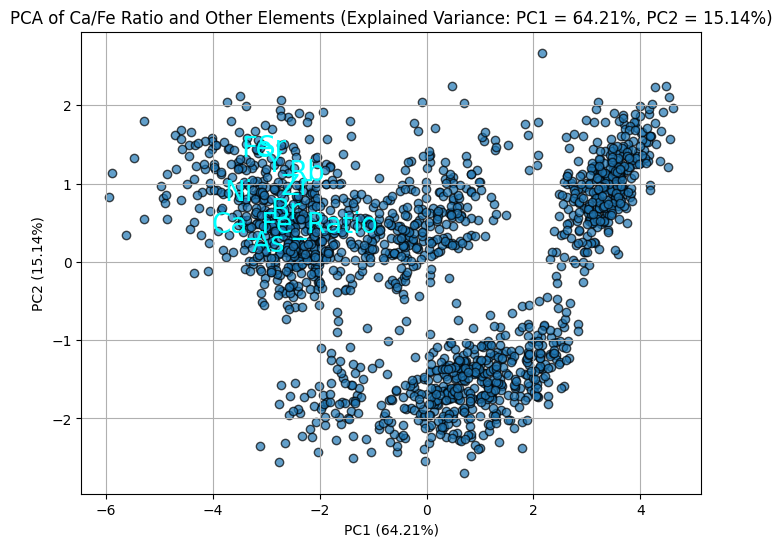

In [23]:
# Calculate the Ca/Fe ratio and add it as a new column
xrf_file['Ca_Fe_Ratio'] = xrf_file['Ca'] / xrf_file['Fe']

# Select the columns to include in the PCA (Ca/Fe ratio + other elements)
elements_for_pca = ['Ca_Fe_Ratio', 'Fe', 'Ni', 'As', 'Br', 'Rb', 'Sr', 'Y', 'Zr']

# Extract the relevant columns for PCA
x = xrf_file[elements_for_pca].values

# Standardize the data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Perform PCA
pca = PCA(n_components=2)  # We want the first two components (PC1, PC2)
pca_components = pca.fit_transform(x_scaled)

# Extract the explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Create a DataFrame for the PCA components
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])

# Plot the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7, edgecolor='k')

# Add labels for each element (use element names instead of depths)
for i, element in enumerate(elements_for_pca):
    plt.text(pca_df['PC1'][i] + 0.05, pca_df['PC2'][i] + 0.05, element, fontsize=20, alpha=1.0, ha='left', va='bottom', color='cyan')

# Title with explained variance for each component
plt.title(f'PCA of Ca/Fe Ratio and Other Elements (Explained Variance: PC1 = {explained_variance[0]*100:.2f}%, PC2 = {explained_variance[1]*100:.2f}%)')

# Labels for axes
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)')

# Add grid
plt.grid(True)

# Show the plot
plt.show()


Again, we see three distinct clusters that appear in PCA space.  Whether this is meaningful I am not sure, but we've changed the values of our 2 axes.  By calculating Ca/Fe ratios, we have increased the importance of our PC2, adding some multi-dimensionality to this dataset.  This suggests that Ca/Fe does have some importance in this dataset.

Even without Ag, labels are still clustered in the top left, despite 3 distinct clusters appearing in the data.  I am not sure if this is real or artifact of the data, so I will move on to KMEANS

# KMEANS

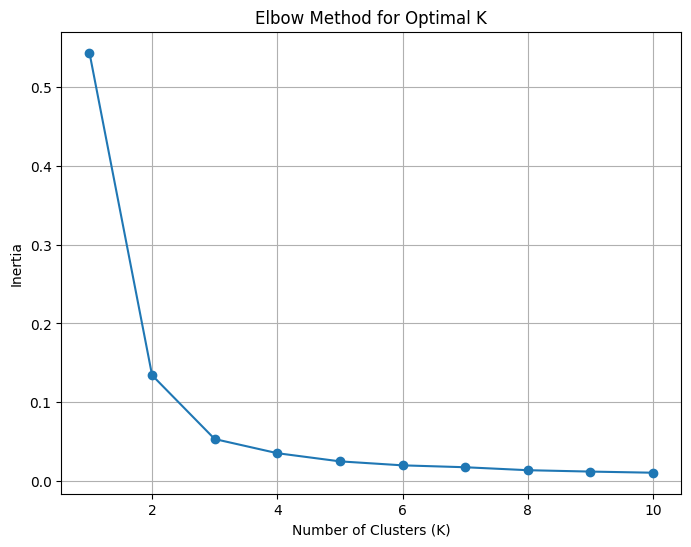

In [24]:
# Choose the elemental features for clustering (e.g., Ca, Fe, Ni, etc.)
elemental_features = ['Ca', 'Fe', 'Ni', 'As', 'Br', 'Rb', 'Sr', 'Y', 'Zr']

# Extract the data from the xrf_file
x = xrf_file[elemental_features].values

# Elbow method to find the optimal number of clusters (K)
inertia = []
for k in range(1, 11):  # Check values of K from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


The elbow test allows us to determine how many clusters are optimal to test through KMEANS. You want the minimum inertia but als the minimum amount of clusters, so you want to pick from the "elbow" of the data.  Here, this suggests that 3 is the optimal amount of clusters to use.

The elbow test may not always be that good, so instead lets do a Sillouette scoring test.

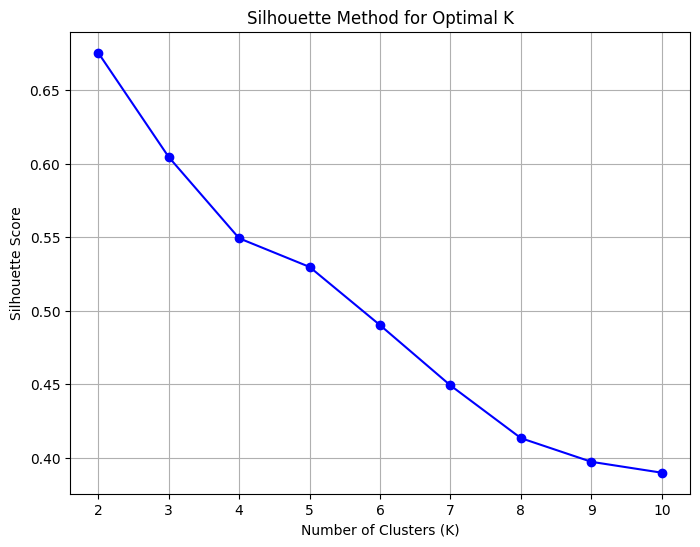

In [25]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Choose the elemental features for clustering
elemental_features = ['Ca', 'Fe', 'Ni', 'As', 'Br', 'Rb', 'Sr', 'Y', 'Zr']

# Extract the data from the xrf_file
x = xrf_file[elemental_features].values

# Silhouette method to find the optimal number of clusters (K)
silhouette_scores = []
for k in range(2, 11):  # Silhouette score requires at least 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(x)
    score = silhouette_score(x, cluster_labels)
    silhouette_scores.append(score)

# Plot the Silhouette Scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='b')
plt.title('Silhouette Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


The sillouette Test suggests that we use 2 clusters rather than 3, so lets do both and compare the answers

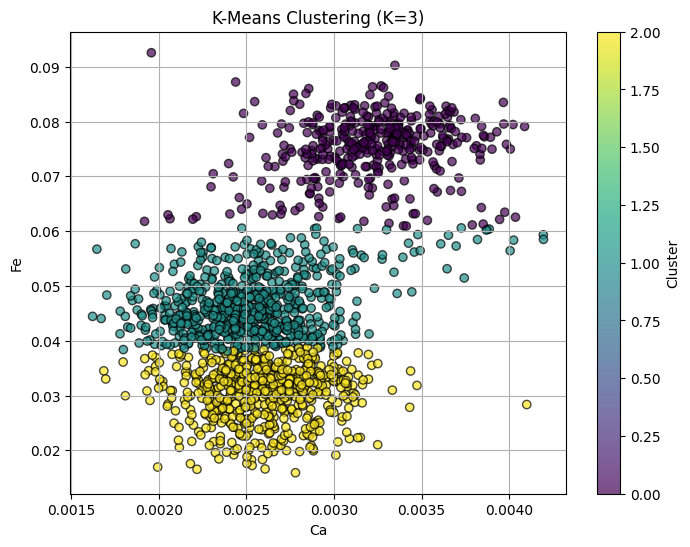

In [ ]:
# Fit K-Means with the chosen number of clusters (e.g., K=3)
k = 3  # Choose based on the elbow method
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x)

# Add the cluster labels to your DataFrame
xrf_file['Cluster'] = kmeans.labels_

# Visualize the data with the clusters
plt.figure(figsize=(8, 6))

# Scatter plot with color-coded clusters
plt.scatter(xrf_file['Ca'], xrf_file['Fe'], c=xrf_file['Cluster'], cmap='viridis', alpha=0.7, edgecolor='k')

# Title and labels
plt.title(f'K-Means Clustering (K={k})')
plt.xlabel('Ca')
plt.ylabel('Fe')
plt.colorbar(label='Cluster')

# Show the plot
plt.grid(True)
plt.show()


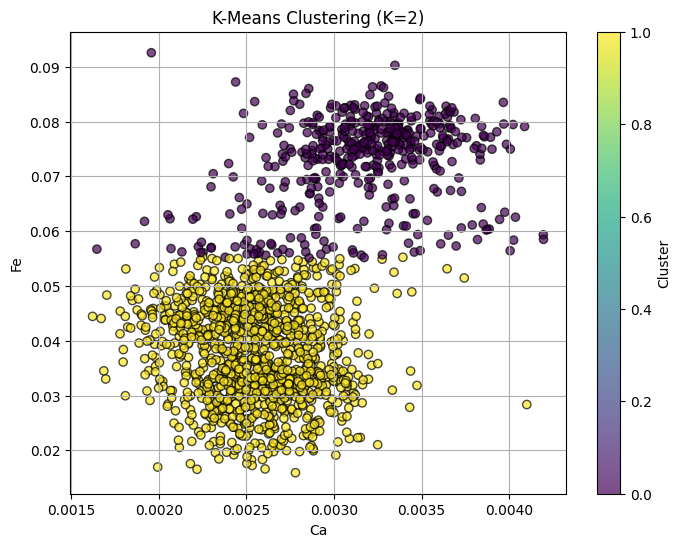

In [26]:
# Fit K-Means with the chosen number of clusters (e.g., K=2)
k = 2  # Choose based on the elbow method
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(x)

# Add the cluster labels to your DataFrame
xrf_file['Cluster'] = kmeans.labels_

# Visualize the data with the clusters
plt.figure(figsize=(8, 6))

# Scatter plot with color-coded clusters
plt.scatter(xrf_file['Ca'], xrf_file['Fe'], c=xrf_file['Cluster'], cmap='viridis', alpha=0.7, edgecolor='k')

# Title and labels
plt.title(f'K-Means Clustering (K={k})')
plt.xlabel('Ca')
plt.ylabel('Fe')
plt.colorbar(label='Cluster')

# Show the plot
plt.grid(True)
plt.show()


This KMEANS clustering identified 3 major clusters, as we asked it to, based off of Fe and Ca.  This shows more distinct clustering at higher Fe and Ca concentration.  The bottom left to upper right trend suggests that, at higher concentrations, the two may be found together.  This might be indicative of carbonate or clay, both which have Ca and Fe in their compositions.  When using 2 clusters, we see a lower Ca/Fe group and a higher Ca/Fe group.

You could take this cluster and examine which depths they are derived from. This would allow you to identify units of specific Ca and Fe compositions.  Lets try below

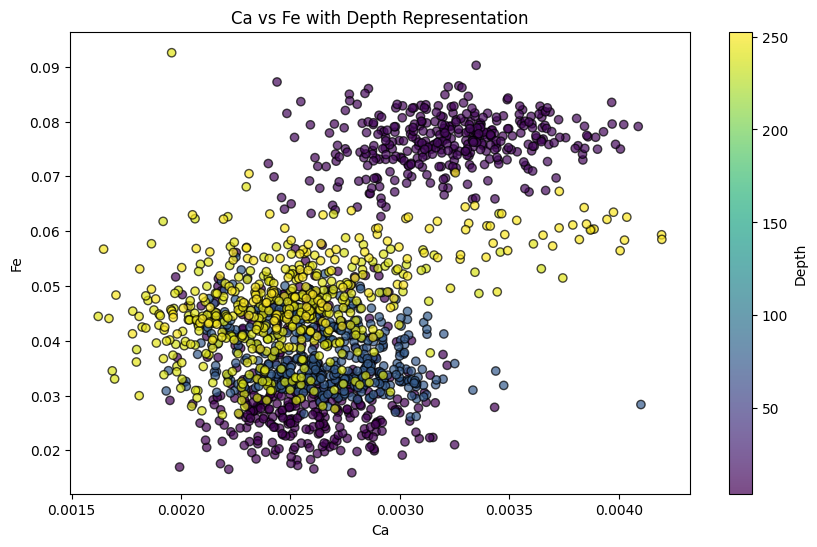

In [27]:
# Create the plot with color representing depth
plt.figure(figsize=(10, 6))

# Scatter plot for Ca and Fe with color based on depth
scatter = plt.scatter(xrf_file['Ca'], xrf_file['Fe'], c=xrf_file['Depth'], cmap='viridis', alpha=0.7, edgecolor='k')

# Add a colorbar to represent depth
plt.colorbar(scatter, label='Depth')

# Title and labels
plt.title("Ca vs Fe with Depth Representation")
plt.xlabel('Ca')
plt.ylabel('Fe')

# Show the plot
plt.show()



This provides some interesting information. It appears that the deepest depths have moderate Ca and Fe abundances.  Useful? Possibly, but it hints as to where in the core you could find different relative concentrations of each.  Lets see if we can extract any more information out of this dataset with Gaussian Mixture Modelling (GMM).  I chose this approach because it can be useful to identify the data as being a mixture of distributions.  This data inherently is.  Because the dataset measures 8 different elements, they are going to be present in different quantities throughout the entire dataset.  

# Gaussian Mixture Modelling

Like in the elbow and sillouette test before, lets determine how many clusters we should use so we dont have to rely on eyeballing it

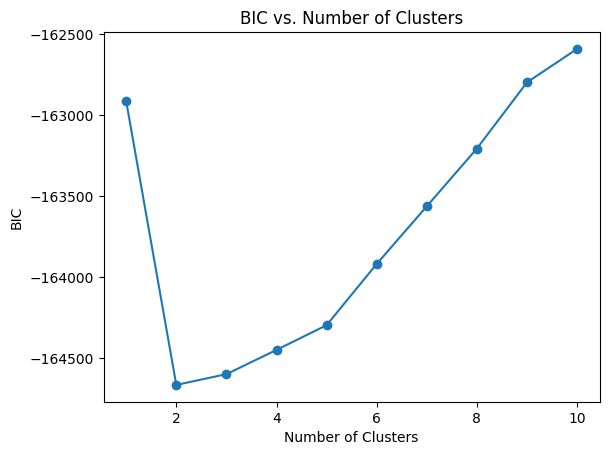

Optimal number of clusters based on BIC: 2


In [28]:
# Extracting the data (no NaN values, as GMM does not handle NaNs)
x = xrf_file[elemental_features].dropna()  # Drop rows with NaN values for simplicity

# Try different values of n_components (number of clusters)
bic_values = []
n_components_range = range(1, 11)  # Try 1 to 10 clusters

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(x)
    bic_values.append(gmm.bic(x))  # Store the BIC for each number of clusters

# Plot BIC values to find the "elbow" where the optimal number of clusters is
plt.plot(n_components_range, bic_values, marker='o')
plt.title('BIC vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')
plt.show()

# Find the optimal number of clusters based on the lowest BIC
optimal_n_clusters = n_components_range[bic_values.index(min(bic_values))]
print(f"Optimal number of clusters based on BIC: {optimal_n_clusters}")


Thats weird!  A V shape could mean that there is a bimodal distribution in the data, or that relationships are non-linear (which might make sense based on the amount of variables we are trying to plot). I am not really sure how to approach it, so I am going to start with 2 clusters and that appears to be some kind of meaningful based off this BIC test

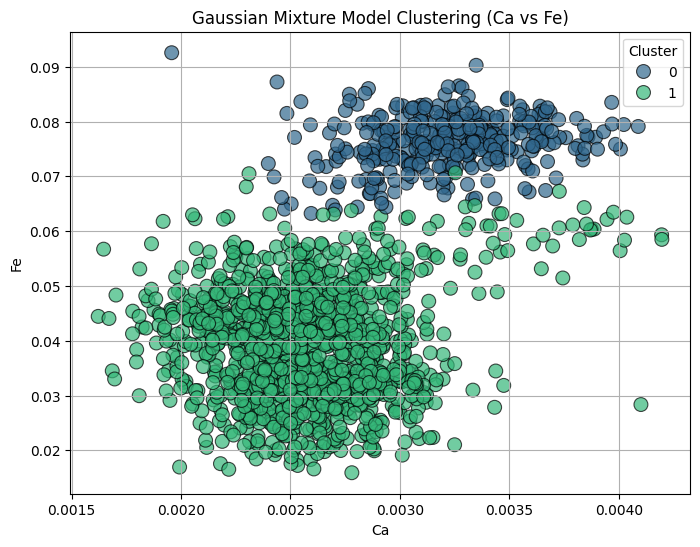

Cluster centers (mean of each Gaussian component):
[[0.00321868 0.07627193 0.01430522 0.0003059  0.00195517 0.00378476
  0.008947   0.00114771 0.00811863]
 [0.00257823 0.03933052 0.01456754 0.00027398 0.00297443 0.00256992
  0.00517429 0.00067462 0.00552277]]


In [29]:
# Assuming your xrf_file is loaded and contains the relevant elemental features
elemental_features = ['Ca', 'Fe', 'Ni', 'As', 'Br', 'Rb', 'Sr', 'Y', 'Zr']  # Adjust based on your dataset

# Extracting the data (no NaN values, as GMM does not handle NaNs)
x = xrf_file[elemental_features].dropna()  # Drop rows with NaN values for simplicity

# Fit a Gaussian Mixture Model
gmm = GaussianMixture(n_components=2)  # Experiment with the number of components (clusters)
gmm.fit(x)  # Fit the model on the raw data (no added 'Cluster' column)

# Predict the cluster labels based on the fitted model
labels = gmm.predict(x)

# Add the predicted labels to the original DataFrame for analysis
xrf_file['Cluster'] = labels  # Add cluster labels to the original dataset

# Now plot the data, using the cluster labels to color the points
plt.figure(figsize=(8, 6))
sns.scatterplot(data=xrf_file, x='Ca', y='Fe', hue='Cluster', palette='viridis', s=100, alpha=0.7, edgecolor='k')
plt.title('Gaussian Mixture Model Clustering (Ca vs Fe)')
plt.xlabel('Ca')
plt.ylabel('Fe')
plt.grid(True)
plt.show()

# Optional: Check the cluster centers (the means of the Gaussian components)
print("Cluster centers (mean of each Gaussian component):")
print(gmm.means_)

# Optionally, you can also check the probabilities of each data point belonging to each cluster
probabilities = gmm.predict_proba(x)


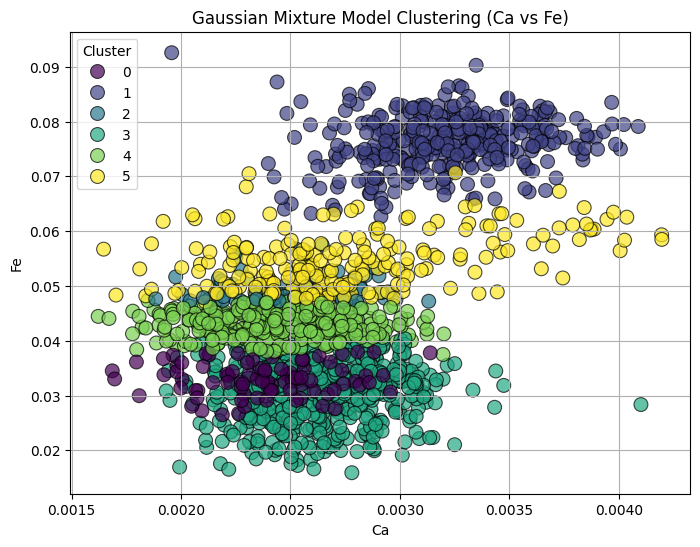

Cluster centers (mean of each Gaussian component):
[[0.00251935 0.03387464 0.01463044 0.00025969 0.00293992 0.00205436
  0.00475458 0.00055823 0.00466324]
 [0.00321942 0.07628665 0.01431294 0.000306   0.00195867 0.0037869
  0.00895337 0.0011483  0.00812292]
 [0.00248477 0.0466573  0.0138021  0.0002873  0.00214399 0.00303823
  0.00555089 0.00077683 0.00630761]
 [0.00262357 0.03018545 0.01608584 0.00026299 0.00443501 0.00214076
  0.00474231 0.00055638 0.00471996]
 [0.00247184 0.04342031 0.01400189 0.00028855 0.00229671 0.00291719
  0.00541919 0.00075048 0.00615967]
 [0.00275435 0.05440835 0.01226029 0.00028094 0.00111535 0.00317082
  0.00592743 0.00086982 0.00665266]]


In [ ]:
# Assuming your xrf_file is loaded and contains the relevant elemental features
elemental_features = ['Ca', 'Fe', 'Ni', 'As', 'Br', 'Rb', 'Sr', 'Y', 'Zr']  # Adjust based on your dataset

# Extracting the data (no NaN values, as GMM does not handle NaNs)
x = xrf_file[elemental_features].dropna()  # Drop rows with NaN values for simplicity

# Fit a Gaussian Mixture Model
gmm = GaussianMixture(n_components=6)  # Experiment with the number of components (clusters)
gmm.fit(x)  # Fit the model on the raw data (no added 'Cluster' column)

# Predict the cluster labels based on the fitted model
labels = gmm.predict(x)

# Add the predicted labels to the original DataFrame for analysis
xrf_file['Cluster'] = labels  # Add cluster labels to the original dataset

# Now plot the data, using the cluster labels to color the points
plt.figure(figsize=(8, 6))
sns.scatterplot(data=xrf_file, x='Ca', y='Fe', hue='Cluster', palette='viridis', s=100, alpha=0.7, edgecolor='k')
plt.title('Gaussian Mixture Model Clustering (Ca vs Fe)')
plt.xlabel('Ca')
plt.ylabel('Fe')
plt.grid(True)
plt.show()

# Optional: Check the cluster centers (the means of the Gaussian components)
print("Cluster centers (mean of each Gaussian component):")
print(gmm.means_)

# Optionally, you can also check the probabilities of each data point belonging to each cluster
probabilities = gmm.predict_proba(x)


With 2 clusters, there seems a distinct divide between samples with high Ca and Fe and samples with low to moderate Fe and Ca.  These could represent 2 end-members that could be explored further, but this suggests that there is a significance between these two elememnts in this whole dataset.  We have also verified the presence of 2 clusters with KMEANS and GMM.

6 clusters had a moderate BIC value, so I thought it would be interesting to see how the GMM clustered these data.  This test made a 6 clusters, several of which overlap.  We continue to have a distinctive cluster at higher Ca and Fe, but the bottom larger cluster is now broken up into clusters with the same Fe but different Ca values.  This type of clustering would be useful to examine Ca/Fe fluctuation through the core.


# Reflection

I learned a good deal through this excersize.  I am still not positive how useful any of these tests were in terms of XRF data, but I definitely learned a lot about what goes into these tests.


Using this information, I would next compare Ca/Fe ratios against other data like density, color, reflectance, or others to examine relationships between those using PCA, KMEANS, and GMMs.  


1. The clustering techniques were more meaningful.  Both KMEANS and GMM identified similar clusters of data related to Fe and Ca, suggesting to me that these were meaningful and reproducible clusters in this dataset.

2. Of these tests, I struggled with PCA the most.  I am not sure if that is due to a misuse of data going into these datasets, but I did not find the data I got from PCA to be particularly meaningful in this dataset.  


3. For PCA, you would score a dataset with an explained variance ratio, which measures how much variance is retained in the test.  For KMEANS, you would score with the sillouette score, which tells how similar a point is to its cluster compared to other clusters. For GMM, you could also use a sillouette score, but you could also use a baysian information criterion (BIC), which penalizes model complexity while rewarding good fit, finding a balance between complexity and precision.

4. I have learned that there is definitely a relationship between Ca and Fe.  This has been reproduced through the KMEANS test and the set of GMMs I ran.  There appears to be a positive relationship between the two, and 2 distinct clusters appear, one at low to moderate Fe and Ca, and one at high Fe and Ca values.  I was not very successful in comparing these data to Magnetic Susceptibility.  I am not sure if that is because it is a complex relationship or because of the methods that I used, but I struggled to find a quantifiable relationship between elements and MS.

5. Using this information, I would next compare Ca/Fe ratios against other data like density, color, reflectance, or others to examine relationships between those using PCA, KMEANS, and GMMs.  

  Next, I would also want to compare cores and see if there are resolveable patterns in Ca/Fe or other physical properties.  It would be interesting to use machine learning techniques to correlate these cores, although I am not positive if this will be possible.  

  Ultimately, I want to use ML techniques to compare sedimentological, micropaleontological, and geochemical data in surface sediments as they compare to seafloor geomorphometry.  I think this would be possible using clustering and PCA (if I can get that working).  I would also want to use all these data to perform correlations between cores and regions, and I would be excited to learn the best ways I could use ML to do this.  

6. I did a small amount of pre-processing, which is outlined in the code above.  I first had to merge the XRF and MS datasets, which was a challenge because they were not measured at identical intervals.  To do this, I performed a nearest neighbor merge which took real XRF and MS data and took the closest approximate depth to merge the two datasets onto the same depth scale.  I think this got me close to an accurate representation of both datasets.  I also had to normalize the XRF data, as each sample is not scanned at the same resolution, so normalization makes it possible to compare elemental abundances (represented in area), which is what raw XRF data is measured in.  

7. In order to PCA XRF and MS data, I think the data would need to be standardized, but I couldn't get this working so I ended up with PCA that I don't think was very meaningful.  I would love to hear how best I could actually compare these variables.